In [1]:
import os
print(os.getcwd())

c:\python\DAT264x Identifying Topics in World Bank Publications-20191110


In [2]:
# 套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from string import punctuation
stop = stopwords.words('english')

In [3]:
# 讀取 train data
train = pd.read_csv('train_values.csv')
train_label = pd.read_csv('train_labels.csv')
test = pd.read_csv('test_values.csv')

In [4]:
# 檢查數據
train.shape , train_label.shape, test.shape # 筆數正確

((18687, 2), (18687, 25), (18699, 2))

In [5]:
# 拿高分的資料清除位置
def rm_tags(text):
    re_tag = r'<[^>]+>'
    text = text.lower()
    
    # 連字
    text = re.sub(re_tag, '', text)
    text = re.sub(r"didn't","did not", text)
    text = re.sub(r"haven't","have not", text)
    text = re.sub(r"can't","can not", text)
    text = re.sub(r"it's","it is", text)
    text = re.sub(r"won't","will not", text)
    text = re.sub(r"wouldn't","would not",text)
    text = re.sub(r"what’s", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    
    # remove non-ascii characters
    text = ''.join(character for character in text if ord(character) < 128)    
    
    # 請繼續加入    
    text = re.sub(r"[&-/()),%']", ' ', text) #這特殊符號都去除
    text = re.sub(r"\.", ' ', text) # 點換成一個空白
    text = re.sub(r"\s+", ' ', text) #多空白換成一個空白
    
    text = ' '.join([c for c in text.split() if c not in stop])    
    text = ' '.join([c for c in text.split() if not c.isdigit()])
    text = ' '.join([c for c in text.split() if c not in punctuation])
    
    return text

In [6]:
# 原始資料
train['doc_text'][0]

'84327 v2\nThe findings, interpretations, and conclusions expressed in this report do not\nnecessarily reflect the views and position of the Executive Directors of the\nWorld Bank, the European Union, or the Government of Romania.\nTABLE OF CONTENTs                                                                                                           Table of Contents\nList of Abbreviations ........................................................................................         7\n\nRomanias growth poles policy has shaped an important part of the\ncountrys development in recent years .........................................................                        9\n\nThe current growth poles policy includes several positive features .......                                             11\n                                                                                                                             3 Policies adapted to the expected evolution of growth poles ...

In [7]:
# 驗證資料處理
rm_tags(train['doc_text'][0])

'v2 findings interpretations conclusions expressed report necessarily reflect views position executive directors world bank european union government romania table contents table contents list abbreviations romanias growth poles policy shaped important part countrys development recent years current growth poles policy includes several positive features policies adapted expected evolution growth poles hand current growth poles policy shortcomings planning growth poles beyond defined metropolitan boundaries based areas economic growth potential new urban systems approach romania currently prepared dg regional development within ministry regional truly integrated programs development public administration mrdpa several recommendations worth considering future 6k eep number growth poles regions stay consider different number urban development poles growth poles policy equally important rather targeting public investments consider polarizing effect bucureti within south region programs citi

In [8]:
%%time
# ********************************************************* 請注意
train['doc_text_cleaned'] = train.doc_text.apply(rm_tags)
test['doc_text_cleaned'] = test.doc_text.apply(rm_tags)
#train, test =  pd.read_pickle("./train20191110.pkl"),  pd.read_pickle("./test20191110.pkl")

Wall time: 4min 50s


In [9]:
# 儲存已經清除完成數據 *********************************請注意
train.to_pickle("./train20191110.pkl")
test.to_pickle("./test20191110.pkl")
print('Save to pickle done!!')

Save to pickle done!!


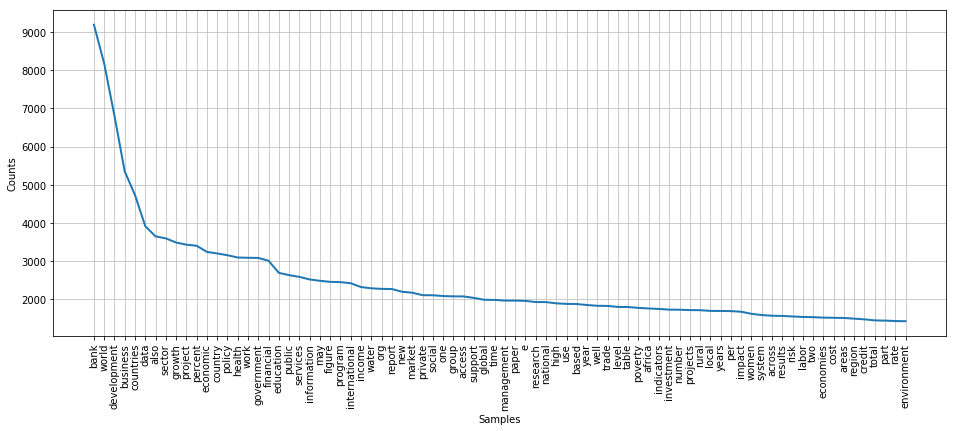

In [10]:
# 找出文字出現的頻率
from nltk import FreqDist
sample = train.loc[:1000, 'doc_text_cleaned']
# for k in sample.values.tolist():
#     for j in k.split():
#         print(j)
#[j for k in sample.values.tolist() for j in k.split() ]
plt.figure(figsize=(16,6) )
FreqDistSend = FreqDist( [j for k in sample.values.tolist() for j in k.split() ]  )
FreqDistSend.plot(80)
plt.show()

In [11]:
categories = train_label.iloc[:, 1:].columns.values.tolist()

In [12]:
# 注意這邊是前幾 N 筆
# y 因為有row_id 要移除 所有 iloc[:, 1:]
top = 100 #*************************************************************注意
X, y = train['doc_text_cleaned'][:] , train_label.iloc[:, 1:]
# X : Series
# y : DataFrame

In [13]:
# 準備建立模型 - 統計模型
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer  # 找出所有的單字
from sklearn.feature_extraction.text import TfidfVectorizer # 加上權重
from sklearn.feature_extraction.text import TfidfTransformer # 加上權重
from sklearn.linear_model import LogisticRegression # 多標籤分類
from sklearn.pipeline import Pipeline # pipline上述的作業
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# *****************************ngram_range=(1, N) N可以是 3,4,5,6
pipeline = Pipeline([
    ('vect', CountVectorizer( ngram_range=(1, 4)  )),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LinearSVC(multi_class='ovr'))  ),
])

In [14]:
%%time
# 給資料進行訓練 Machine Learning - Statistics Model 
pipeline.fit(X_train, y_train)

Wall time: 16min 58s


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 4), preprocessor=None, stop_words=None,
        strip..._class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=None))])

In [15]:
from sklearn.metrics import accuracy_score
prediction = pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test.values, prediction)))

report = metrics.classification_report(y_test, prediction, target_names=categories)
print(report)

Test accuracy is 0.3044408774745853
                                            precision    recall  f1-score   support

information_and_communication_technologies       0.68      0.18      0.29        83
                                governance       0.81      0.44      0.57       170
                         urban_development       0.71      0.50      0.59       143
                       law_and_development       0.79      0.42      0.55       260
                 public_sector_development       0.75      0.45      0.57       284
                               agriculture       0.61      0.49      0.54       117
         communities_and_human_settlements       0.71      0.52      0.60       157
       health_and_nutrition_and_population       0.78      0.62      0.69       316
                   culture_and_development       0.71      0.17      0.28        29
              social_protections_and_labor       0.77      0.40      0.52       222
         international_economics_and_tr

c:\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [16]:
####################
# 準備submission資料
####################
X_submission = test.doc_text_cleaned
X_submission.shape

(18699,)

In [17]:
# 預測資料  一定要全部
prediction_test = pipeline.predict(X_submission[:])
print(prediction_test)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [18]:
# 將預測結果轉換成csv
print(prediction_test.shape)
print(len(categories))
final = pd.DataFrame(prediction_test, columns=categories)

(18699, 24)
24


In [19]:
# 匯出
import os
output = final.reset_index()
output.columns =['row_id']+categories
output.to_csv('submission_format_20191110_3_LinearSVC.csv', sep=',', index=None)
print(os.getcwd())

c:\python\DAT264x Identifying Topics in World Bank Publications-20191110


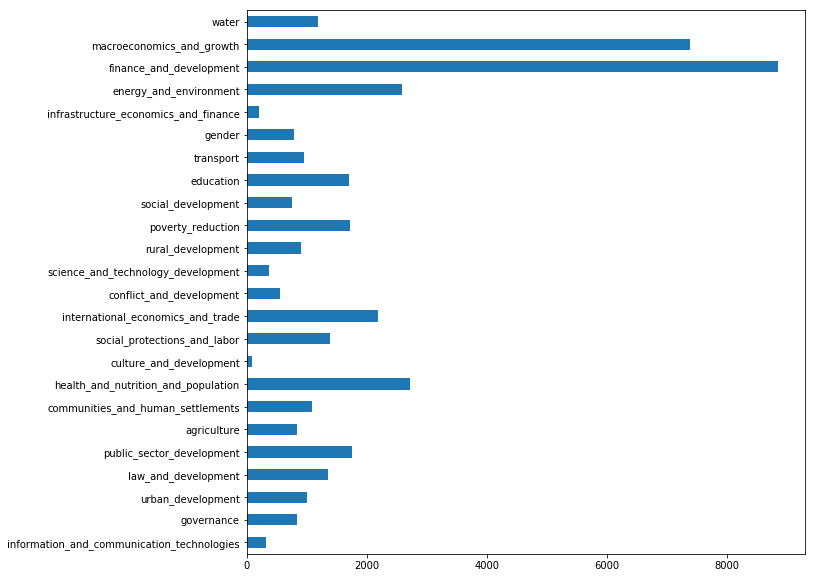

In [20]:
# 分析final submission
plt.figure(figsize=(10,10))
np.sum(final[categories] , axis=0).plot(kind='barh')
plt.show()